In [1]:
%pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, maxabs_scale, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

Загрузка данных

In [3]:
# Загрузка данных
df = pd.read_csv('datasets/Advertising.csv')
df.drop(df.columns[[0]], axis=1, inplace=True)

# Определение входных переменных и целевой переменной
X = df[['TV', 'radio', 'newspaper']]
y = df['sales']


Линейная регрессия

In [4]:
results = []

for n_features in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :n_features + 1], y, test_size=0.3, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Кол-во параметров': n_features + 1,
        'MSE': mean_squared_error(y_test, y_pred),
        'Коэффициенты': ', '.join([f'{coef:.10f}' for coef in model.coef_]),
        'Перехват': model.intercept_
    })

results = pd.DataFrame(results)

Линейная регрессия с разным кол-вом входных параметров

In [5]:
results

,Кол-во параметров,MSE,Коэффициенты,Перехват
0,1,8.970991,0.0464078021,7.239460
1,2,3.669047,"0.0440773641, 0.2026056595",2.837617
2,3,3.796797,"0.0440592810, 0.1992874969, 0.0068824522",2.708949


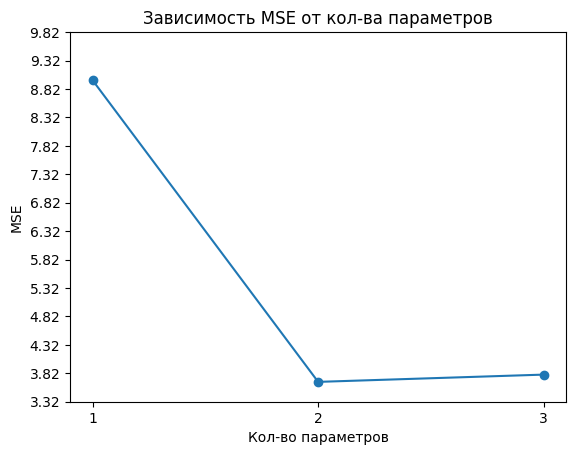

In [6]:
plt.plot(results['Кол-во параметров'], results['MSE'], marker='o')
plt.xlabel('Кол-во параметров')
plt.xticks(results['Кол-во параметров'])
plt.yticks(np.round(np.arange(min(results['MSE']) - 0.35, max(results['MSE']) + 1, 0.5), 2))
plt.ylabel('MSE')
plt.title('Зависимость MSE от кол-ва параметров')
plt.show()

Полиномиальная регрессия и зависимость MSE от степени полинома

In [7]:
max_pow = 10
X_maxabs = maxabs_scale(X, axis=0)
mse_values = []
results = []
range_pow = range(1, max_pow + 1)

for degree in range_pow:
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_maxabs)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    results.append({
        'Степень полинома': degree,
        'MSE': f'{mse:.2f}'
    })

results = pd.DataFrame(results)

In [8]:
results

,Степень полинома,MSE
0,1,3.80
1,2,0.52
2,3,0.29
3,4,1.70
4,5,35.36
5,6,39.60
6,7,877108.50
7,8,12354485.34
8,9,12711734.07
9,10,13026379.33


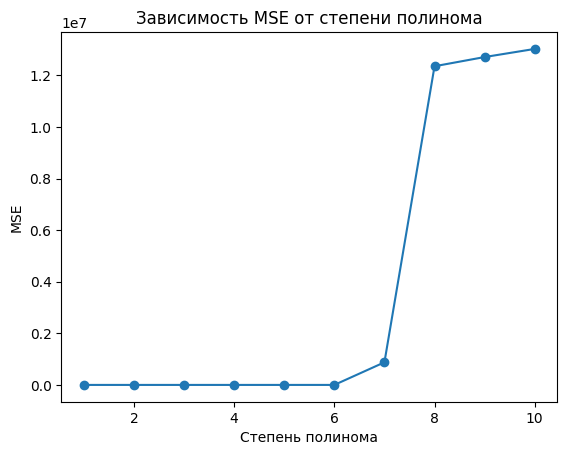

In [9]:
plt.plot(range_pow, mse_values, marker='o')
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.title('Зависимость MSE от степени полинома')
plt.show()

In [10]:
def regression(model_reg, alpha_values, max_degrees):
    X_maxabs = maxabs_scale(X, axis=0)
    best_degree = None
    best_mse = float('inf')
    best_mse_values = []
    mse_degree = {}
    coef_max_degree = {}

    for degree in max_degrees:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X_maxabs)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

        model_mse_values = []
        model_coef_max = []

        for alpha in alpha_values:
            model = model_reg(alpha=alpha)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            model_mse_values.append(mse)
            model_coef_max.append(np.max(np.abs(model.coef_)))
        mse_degree[degree] = model_mse_values
        coef_max_degree[degree] = model_coef_max
        avg_mse = np.mean(model_mse_values)
        best_mse_values.append(avg_mse)

        if avg_mse < best_mse:
            best_mse = avg_mse
            best_degree = degree
    return best_degree, best_mse, mse_degree[best_degree], coef_max_degree[best_degree]

In [11]:
def plots(alpha_values, best_degree, best_mse, mse_values, coef_max):

    print(f'Оптимальная степень полинома: {best_degree} со средним MSE: {best_mse:.3f}')

    plt.figure(figsize=(12, 6))
    plt.plot(alpha_values, mse_values, marker='o', label='MSE')
    plt.plot(alpha_values, coef_max, marker='o', color='r', label='Максимальный модуль параметров')
    plt.xlabel('alpha')
    plt.xscale('log')
    plt.title('Зависимость максимального модуля параметров и MSE от alpha')
    plt.legend()
    plt.show()

In [12]:
max_degrees = range(1, 15)
alpha_values = np.logspace(-3, 3, 100)

Гребневая регрессия и влияние параметра alpha

Оптимальная степень полинома: 11 со средним MSE: 4.525


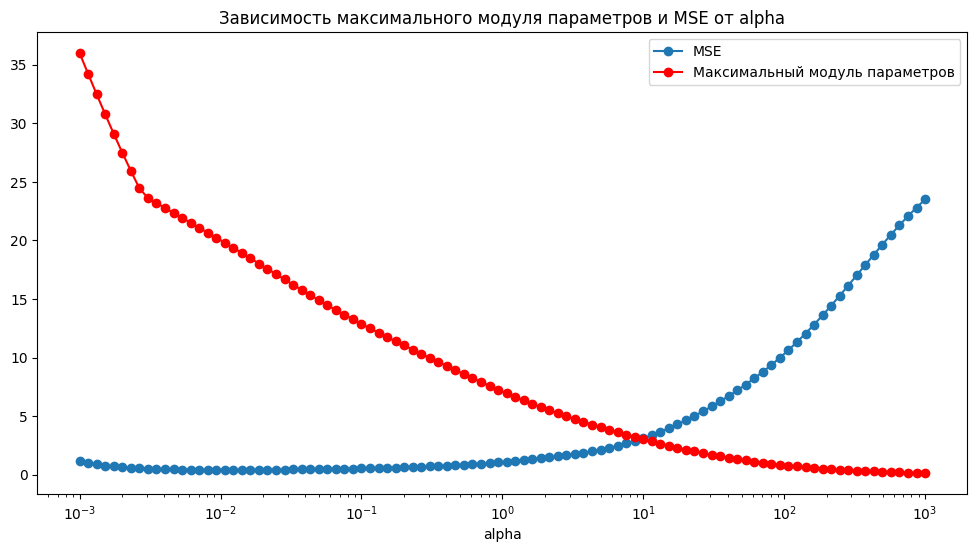

In [13]:
best_degree, best_mse, ridge_mse_values, ridge_coef_max = regression(Ridge, alpha_values, max_degrees)
plots(alpha_values, best_degree, best_mse, ridge_mse_values, ridge_coef_max)

Лассо-регрессия и влияние параметра alpha

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+00, tolerance: 3.674e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e+00, tolerance: 3.674e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+00, tolerance: 3.674e

Оптимальная степень полинома: 7 со средним MSE: 16.027


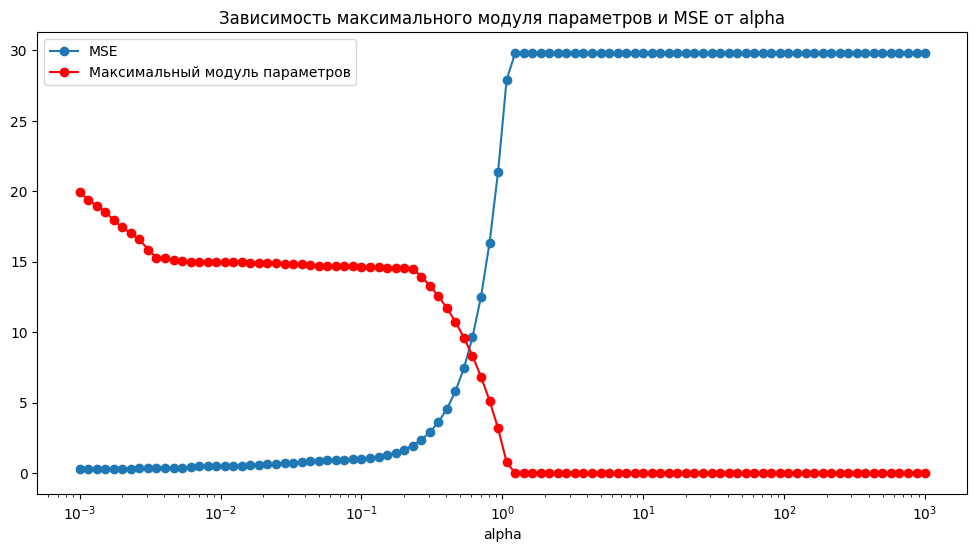

In [14]:
best_degree, best_mse, lasso_mse_values, lasso_coef_max = regression(Lasso, alpha_values, max_degrees)
plots(alpha_values, best_degree, best_mse, lasso_mse_values, lasso_coef_max)

SVR с разными ядрами

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR()

param_grid = {
        'C': [0.1, 1, 10, 100, 1000, 10000],
        'gamma': [0.01, 0.1, 1],
        'epsilon': [0.01, 0.1, 1],
        'degree': [2, 3, 4],
        'kernel': ['poly', 'sigmoid']
    }

In [16]:
grid_search = GridSearchCV(svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'degree': [2, 3, 4], 'epsilon': [0.01, 0.1, 1],
                         'gamma': [0.01, 0.1, 1],
                         'kernel': ['poly', 'sigmoid']},
             scoring='neg_mean_squared_error')

In [17]:
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')

best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE): {mse:.3f}')

print(f'Лучшее ядро: {best_params["kernel"]}')
print(f'Лучшее значение C: {best_params["C"]}')
print(f'Лучшее значение gamma: {best_params["gamma"]}')
print(f'Лучшее значение epsilon: {best_params["epsilon"]}')
if best_params["kernel"] == 'poly':
    print(f'Лучшая степень полинома: {best_params["degree"]}')

Лучшие параметры: {'C': 100, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Среднеквадратичная ошибка (MSE): 3.447
Лучшее ядро: sigmoid
Лучшее значение C: 100
Лучшее значение gamma: 0.01
